## Tria COVID-19 Datathlon
### Seyyid Emre Sofuoglu
#### 04/25/2020

# ___COVID-19 Analysis and Simulations___

## Background and Motivation

For the last 4 months the pandemic has been roaming the earth, putting us to our places (literally). The whole world is affected by it and by far, we have no solutions but running and hiding. Still, a disaster is exactly defined like this and this is an experience to learn from.

So far, there have been many analyses on the spread and biology on COVID-19 by people who are the best of their fields. By no means, I aim to produce something more valuable than those studies but I aim to explore my own country, Turkiye, for which there are not many studies and not many useful data around. I will utilize the existing data for other countries in the world and several models, e.g. SIR, for this. 

I will use publicly available COVID-19 Dataset provided kindly by [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide). In this dataset, we have daily cases and number of deaths. I will try to make a model that will be applicable on different countries with varying circumstances.

## Data
The first data we have is the worldwide data for many countries. Let's have a look.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.integrate import odeint
from scipy.optimize import curve_fit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')

figsizes = (15,6)

In [2]:
world_data = pd.read_csv('data_files/COVID-19-geographic-disbtribution-worldwide-2020-04-24.csv')
world_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,4/24/2020,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia
1,4/23/2020,23,4,2020,84,4,Afghanistan,AF,AFG,37172386.0,Asia
2,4/22/2020,22,4,2020,61,1,Afghanistan,AF,AFG,37172386.0,Asia
3,4/21/2020,21,4,2020,35,2,Afghanistan,AF,AFG,37172386.0,Asia
4,4/20/2020,20,4,2020,88,3,Afghanistan,AF,AFG,37172386.0,Asia


Now, let's have a look at the data on Turkiye.

In [3]:
def excel2datenum(matlab_dates):
    datenums = np.zeros_like(matlab_dates)
    for i in range(len(matlab_dates)):
        mystr = matlab_dates[i]
        res = mystr.rsplit(sep='/')
        res = res[0]+' '+res[1]+' '+res[2]
        res = datetime.strptime(res, '%m %d %Y')
        datenums[i] = datetime.toordinal(res)
    return datenums
world_data['dateRep'] = excel2datenum(world_data['dateRep'])

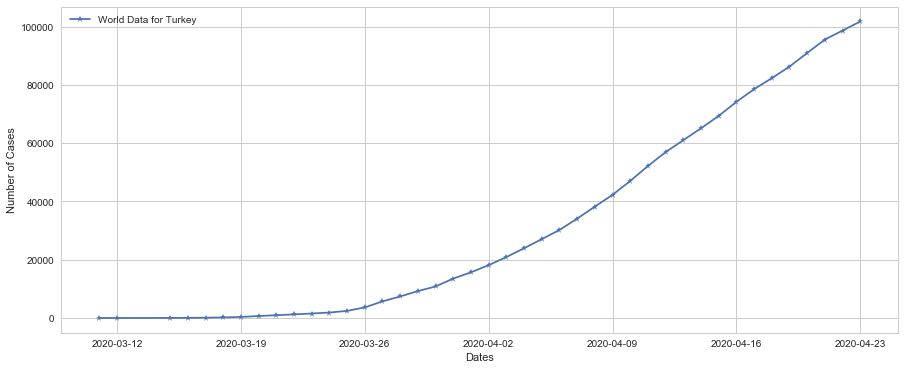

In [4]:
fig = plt.figure(figsize=figsizes)
mask = world_data['countriesAndTerritories']=='Turkey'
dates_fr_world = world_data['dateRep'][mask]
turkiye_from_world = world_data['cases'][mask]
plt.plot_date(dates_fr_world[::-1]-1, np.cumsum(turkiye_from_world[::-1]), '-*', label= 'World Data for Turkey')
plt.ylabel('Number of Cases')
plt.xlabel('Dates')
plt.legend();

It seems that a set of measures by government (Cancelling flights from Europe, Iran, South Kore etc., contact tracing, lots of tests, cancelling schools and universities at March 16th) had a big effect on slowing the pandemic at April 1st. Adding the influences of Italy, Iran and South Korea, these measures probably also helped more people decide on social isolation.

Now, let's see some comparisons between countries taking 100 total case counts as basis, or first day of the spread.

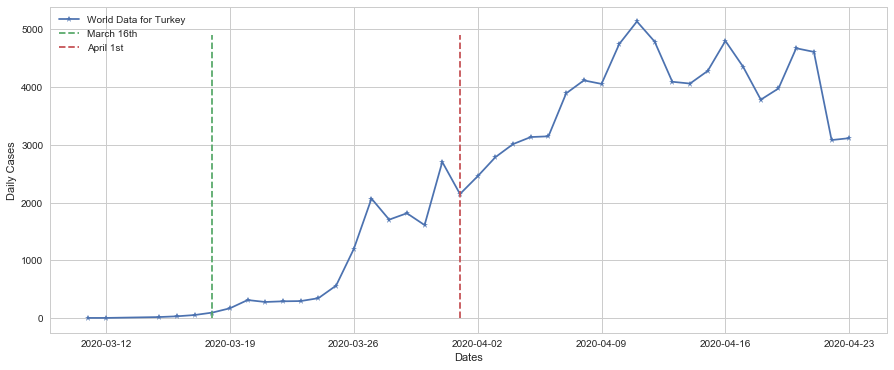

In [5]:
fig = plt.figure(figsize=figsizes)
mask = world_data['countriesAndTerritories']=='Turkey'
dates_fr_world = world_data['dateRep'][mask]
turkiye_from_world = world_data['cases'][mask]
plt.plot_date(dates_fr_world[::-1]-1, turkiye_from_world[::-1], '-*', label= 'World Data for Turkey')
plt.plot_date(np.ones(50)*737502,np.arange(0,5000,100), '--', label='March 16th')
plt.plot_date(np.ones(50)*737516,np.arange(0,5000,100), '--', label='April 1st')
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.legend();

In [6]:
def get_country(data, country, sep=1, ref = 0):
    mask = data['countriesAndTerritories']==country
    dates = data['dateRep'][mask]
    cases = data['cases'][mask]
    deaths = data['deaths'][mask]
    dates = dates.iloc[::-1]
    cases = cases.iloc[::-1]
    deaths = deaths.iloc[::-1]
    dist_from = np.array(np.abs(np.cumsum(cases)-sep))
    offset = max([dist_from.argmin(), np.nonzero(cases)[0][0]])
    if ref==0:
        first = 0
    else:
        first = dates.iloc[offset]
    dates = dates.iloc[offset:] - first + ref
    cases = cases.iloc[offset:]
    deaths = deaths.iloc[offset:]
    return dates, cases, deaths, first
def plot_country(world_data, country, sep=1, ref=0, pl_type='cases'):
    dates, cases, deaths, first = get_country(world_data, country, sep, ref)
    if pl_type=='cases':
        plt.plot_date(dates, cases, '-*', label= country)
    elif pl_type == 'deaths':
        plt.plot_date(dates, deaths, '-*', label= country)
    elif pl_type =='cumcases':
        plt.plot_date(dates, np.cumsum(cases), '-*', label= country)
    elif pl_type =='cumdeaths':
        plt.plot_date(dates, np.cumsum(deaths), '-*', label= country)
    return first

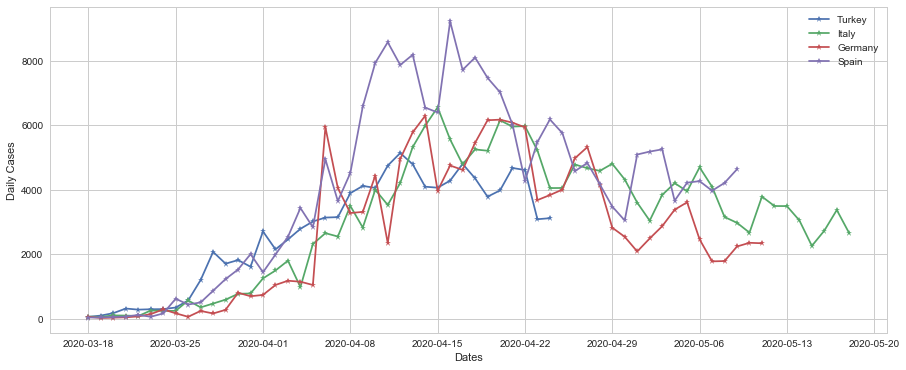

In [7]:
num_tot = 100
fig = plt.figure(figsize=figsizes)
offs = plot_country(world_data, 'Turkey', num_tot, dates_fr_world.iloc[-5])
# plot_country(world_data, 'South_Korea', num_tot, offs)
plot_country(world_data, 'Italy', num_tot, offs)
# plot_country(world_data, 'Iran', num_tot, offs)
plot_country(world_data, 'Germany', num_tot, offs)
plot_country(world_data, 'Spain', num_tot, offs)
plt.xlabel('Dates')
plt.ylabel('Daily Cases')
plt.legend();

We can see that there are similar trends of them all.Spain has a higher peak and Germany has some irregularities. But this is weird, we know that Germany has much less number of deaths than Spain or Italy, so what gives?

Let's see the daily deaths comparisons.

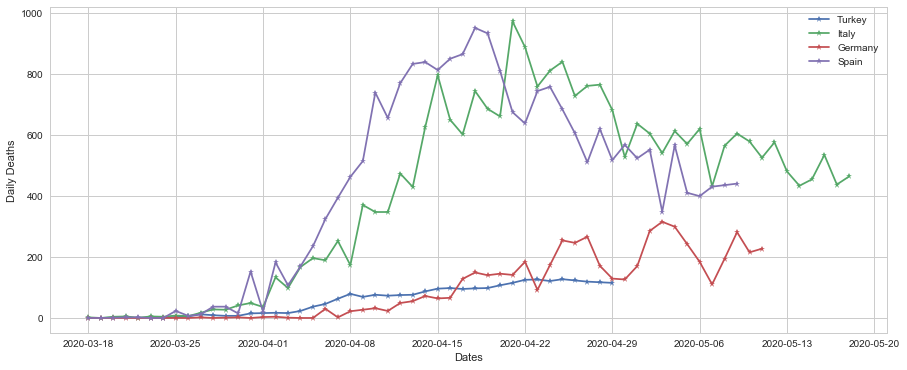

In [8]:
num_tot = 100
col = 'deaths'
fig = plt.figure(figsize=figsizes)
offs = plot_country(world_data, 'Turkey', num_tot, dates_fr_world.iloc[-10], col)
# plot_country(world_data, 'United_States_of_America', num_tot, offs, col)
plot_country(world_data, 'Italy', num_tot, offs, col)
# plot_country(world_data, 'Iran', num_tot, offs, col)
plot_country(world_data, 'Germany', num_tot, offs, col)
plot_country(world_data, 'Spain', num_tot, offs, col)
plt.xlabel('Dates')
plt.ylabel('Daily Deaths')
plt.legend();

We can see that Germany and Turkey now has much better picture compared to Italy and Spain. What might be the cause? What helped these countries achieve such low figures? 

Now let's analyze the data using models like SIR.

## Methodology

[SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) is a compartmental model well known in epidemiology. Using this model, we will try to analyze various countries and try to see parameter variations among them.

In SIR models:
* **S** is very often used for "susceptible" to refer to people who can get a disease (some people may have some immunity).
* **I** refers to "infected", which means they have the disease; in many cases this is called **L** so that **I** can be used to refer to those that are infectious (i.e. can spread the disease).
* **R** refers to "recovered" or "removed".
* Another compartment we can use for our purposes is "deceased" **D**. The pandemic has a high death toll, so this is reasonable.

The model is governed by a set of differential equations which explain the transition between the compartments:
$$\frac{dS}{dt} = - \frac{\beta I S}{N},$$
$$\frac{dI}{dt} = \frac{\beta I S}{N}-\gamma I - \mu I,$$
$$\frac{dR}{dt} = \gamma I,$$
$$\frac{dD}{dt} = \mu I,$$
where $N$ corresponds to the total population. We know that with increaseing number of cases, hospitals run out of ICUs and death rate $\mu$ increases. But let's assume that it doesn't and continue with our analysis.

The model is simplistic. It does not consider changing public dynamics and government measures. It also assumes we have knowledge of all infected. But we will start by this to get some ideas, then improve. Let's define an update function.

In [9]:
# Update rules for SIRD model
def f(y, t, beta, gamma, mu):
        Si = y[0]
        Ii = y[1]
        Ri = y[2]
        Di = y[3]
        N = np.sum(y[0:4])
        # the model equations
        f0 = -beta*Si*Ii/N
        f1 = beta*Si*Ii/N - gamma*Ii - mu*Ii
        f2 = gamma*Ii
        f3 = mu*Ii
        return f0, f1, f2, f3

So, assuming we found the parameters for a country, how do we quantify the results? We can use an estimation error $e$ defined by:

$ e = \frac{\|y-\hat{y}\|_2}{\|y\|_2} $,

where $y$ is the real number of cases as a time series vector, $\hat{y}$ is the vector, or array estimated by the model and $\|.\|_2$ is the $l_2$ norm, defined by: 

$\|x\|_2=\sqrt{\sum_{i=1}^n x_i^2}$.

In [10]:
def error_value(y, y_hat):
    x = y-y_hat
    e = np.sqrt(np.sum(x**2))/np.sqrt(np.sum(y**2))
    return e

Now, the population of Turkey is about 85 millions, Germany is about 84 millions, Italy is about 60 million and Spain, 50. Hubei, in which a big majority of China's cases happened also is about 59 million. These countries all have high test counts, so their data are reliable. They're our candidates for testing our models.

Let's fit the parameters on a couple of countries, e.g. Germany, Spain and Turkey, and see how it looks. 

In [11]:
N = 47*10**6 # Population of Spain.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths

y0 = [S0, I0, R0, D0]

def sird_odeint(t, beta, gamma, mu):
    # Solve DE's
    soln = odeint(f, y0, t, args=(beta, gamma, mu))
    S = soln[:, 0]
    I = soln[:, 1]
    R = soln[:, 2]
    D = soln[:, 3]
    return np.concatenate((I+R+D, D))

def fit_sird(data_fr, country, start = 0, end = -1, sep=0):
    dates, cases, deaths, first = get_country(data_fr, country, sep=sep)
    cases = np.array(np.cumsum(cases))
    deaths = np.array(np.cumsum(deaths))
    start = np.asscalar(np.array(start))
    end = np.asscalar(np.array(end))
    if end == -1:
        end = cases.size
    cases = np.split(cases, [start, end])[1]
    deaths = np.split(deaths, [start, end])[1]
    dates = np.split(np.array(dates), [start, end])[1]
    t = np.arange(len(cases))
    popt, pcov = curve_fit(sird_odeint, t, np.concatenate((cases, deaths)))
    est = sird_odeint(t, popt[0], popt[1], popt[2])
    est_cases, est_deaths = np.split(est, 2)
    return dates, cases, deaths, est_cases, est_deaths, popt
outs_s = fit_sird(world_data, 'Spain')
N = 84*10**6 # Population of Germany and Turkey.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths

y0 = [S0, I0, R0, D0]
outs_g = fit_sird(world_data, 'Germany')
outs_t = fit_sird(world_data, 'Turkey')

The parameters of Spain are: beta(S->I) = 34.59 , gamma(I->R) = 31.05 , mu(I->D) = 3.4468
The parameters of Germany are: beta(S->I) = 20.64 , gamma(I->R) = 19.96 , mu(I->D) = 0.5978
The parameters of Turkey are: beta(S->I) = 33.02 , gamma(I->R) = 31.28 , mu(I->D) = 1.5765


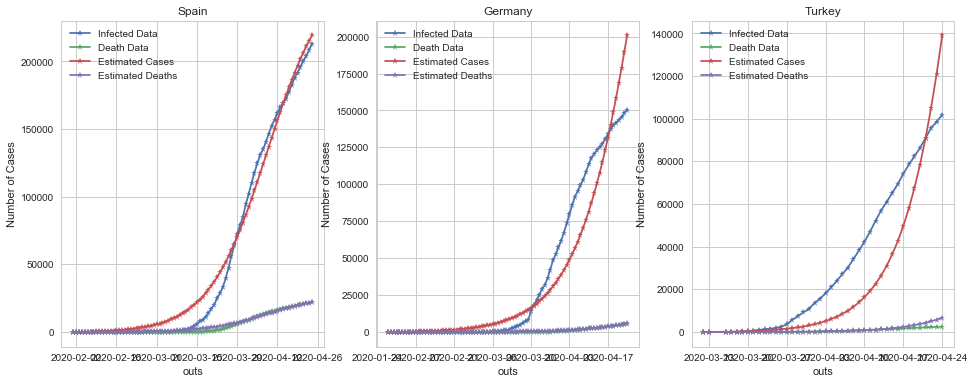

In [12]:
def plot_SGT(outs_s, outs_g, outs_t, logflag=False):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,3,1)
    plt.plot_date(outs_s[0], outs_s[1], '-*', label= 'Infected Data')
    plt.plot_date(outs_s[0], outs_s[2], '-*', label= 'Death Data')
    plt.plot_date(outs_s[0], outs_s[3], '-*', label= 'Estimated Cases')
    plt.plot_date(outs_s[0], outs_s[4], '-*', label= 'Estimated Deaths')
    if logflag:
        ax.set_yscale('log')
        ax.set_ylim([1, None])
    plt.legend()
    plt.title('Spain')
    plt.xlabel('outs')
    plt.ylabel('Number of Cases')
    if len(outs_s[5])==3:
        print('The parameters of Spain are: beta(S->I) =', round(outs_s[5][0],2),
          ', gamma(I->R) =', round(outs_s[5][1],2),', mu(I->D) =', round(outs_s[5][2],4))
    else:
        print('The parameters of Spain at initial stage are: beta(S->I) =', round(outs_s[5][0],2),
              ', gamma(I->R) =', round(outs_s[5][1],2),', mu(I->D) =', round(outs_s[5][2],4))
        print('The parameters of Spain at latter stage are: beta(S->I) =', round(outs_s[5][3],2),
              ', gamma(I->R) =', round(outs_s[5][4],2),', mu(I->D) =', round(outs_s[5][5],4))
        
    ax = fig.add_subplot(1,3,2)
    plt.plot_date(outs_g[0], outs_g[1], '-*', label= 'Infected Data')
    plt.plot_date(outs_g[0], outs_g[2], '-*', label= 'Death Data')
    plt.plot_date(outs_g[0], outs_g[3], '-*', label= 'Estimated Cases')
    plt.plot_date(outs_g[0], outs_g[4], '-*', label= 'Estimated Deaths')
    if logflag:
        ax.set_yscale('log')
        ax.set_ylim([1, None])
    plt.legend()
    plt.title('Germany')
    plt.xlabel('outs')
    plt.ylabel('Number of Cases')
    if len(outs_g[5])==3:
        print('The parameters of Germany are: beta(S->I) =', round(outs_g[5][0],2),
          ', gamma(I->R) =', round(outs_g[5][1],2),', mu(I->D) =', round(outs_g[5][2],4))
    else:
        print('The parameters of Germany at initial stage are: beta(S->I) =', round(outs_g[5][0],2),
              ', gamma(I->R) =', round(outs_g[5][1],2),', mu(I->D) =', round(outs_g[5][2],4))
        print('The parameters of Germany at latter stage are: beta(S->I) =', round(outs_g[5][3],2),
              ', gamma(I->R) =', round(outs_g[5][4],2),', mu(I->D) =', round(outs_g[5][5],4))

    ax = fig.add_subplot(1,3,3)
    plt.plot_date(outs_t[0], outs_t[1], '-*', label= 'Infected Data')
    plt.plot_date(outs_t[0], outs_t[2], '-*', label= 'Death Data')
    plt.plot_date(outs_t[0], outs_t[3], '-*', label= 'Estimated Cases')
    plt.plot_date(outs_t[0], outs_t[4], '-*', label= 'Estimated Deaths')
    if logflag:
        ax.set_yscale('log')
        ax.set_ylim([1, None])
    plt.legend()
    plt.title('Turkey')
    plt.xlabel('outs')
    plt.ylabel('Number of Cases')
    if len(outs_t[5])==3:
        print('The parameters of Turkey are: beta(S->I) =', round(outs_t[5][0],2),
          ', gamma(I->R) =', round(outs_t[5][1],2),', mu(I->D) =', round(outs_t[5][2],4))
    else:
        print('The parameters of Turkey at initial stage are: beta(S->I) =', round(outs_t[5][0],2),
              ', gamma(I->R) =', round(outs_t[5][1],2),', mu(I->D) =', round(outs_t[5][2],4))
        print('The parameters of Turkey at latter stage are: beta(S->I) =', round(outs_t[5][3],2),
              ', gamma(I->R) =', round(outs_t[5][4],2),', mu(I->D) =', round(outs_t[5][5],4))
plot_SGT(outs_s, outs_g, outs_t)

In [13]:
print('Error for Spain is:',round(error_value(outs_s[1], outs_s[3]),4))
print('Error for Germany is:',round(error_value(outs_g[1], outs_g[3]),4))
print('Error for Turkey is:',round(error_value(outs_t[1], outs_t[3]),4))

Error for Spain is: 0.0972
Error for Germany is: 0.2469
Error for Turkey is: 0.3585


The fitted curves, while looking similar, are not very accurate. They are unable to model the curvature change. Cases change the curvature at some point, indicating the reaction of the people and government, so the model is undercomplex. Also, we know that the infected might not get symptoms for a while and do not get cured or die in a day, so there should be some delays in changes. 

Let's see how good is the model until the effects of the measures are visible, i.e. 14 days after measures took effect. For Spain we believe it's around 27th of March as this was 14 days after the government issued [a state of alarm](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain#State_of_alarm_(13%E2%80%9327_March)). In Germany, at 13th of March, the government transitioned to [*Protection*](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Germany) stage and wide closures took effect. In Turkey, widespread measures started at March 16th, when the first 100 case thereshold was passed. So let's use March 27th for all these countries as the change point.

In [14]:
N = 47*10**6 # Population of Spain.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths
y0 = [S0, I0, R0, D0]

spain = get_country(world_data, 'Spain', sep=0)
spain_dates = spain[0]
d = datetime.strptime('2020-03-27', '%Y-%m-%d').date()
last = np.where(np.array(spain_dates)==d.toordinal())
outs_s = fit_sird(world_data, 'Spain', end=last)

N =  84000000 # Population of Turkey and Germany are similar.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths

y0 = [S0, I0, R0, D0]

germany = get_country(world_data, 'Germany', sep=0)
germany_dates = germany[0]
d = datetime.strptime('2020-03-27', '%Y-%m-%d').date()
last = np.where(np.array(germany_dates)==d.toordinal())
outs_g = fit_sird(world_data, 'Germany', end=last)
turkey = get_country(world_data, 'Germany', sep=0)
turkey_dates = turkey[0]
d = datetime.strptime('2020-03-30', '%Y-%m-%d').date()
last = np.where(np.array(turkey_dates[::-1])==d.toordinal())
outs_t = fit_sird(world_data, 'Turkey', end=last)

The parameters of Spain are: beta(S->I) = 0.37 , gamma(I->R) = 0.16 , mu(I->D) = 0.0233
The parameters of Germany are: beta(S->I) = 0.13 , gamma(I->R) = -0.05 , mu(I->D) = 0.0006
The parameters of Turkey are: beta(S->I) = 111.42 , gamma(I->R) = 109.02 , mu(I->D) = 2.2317


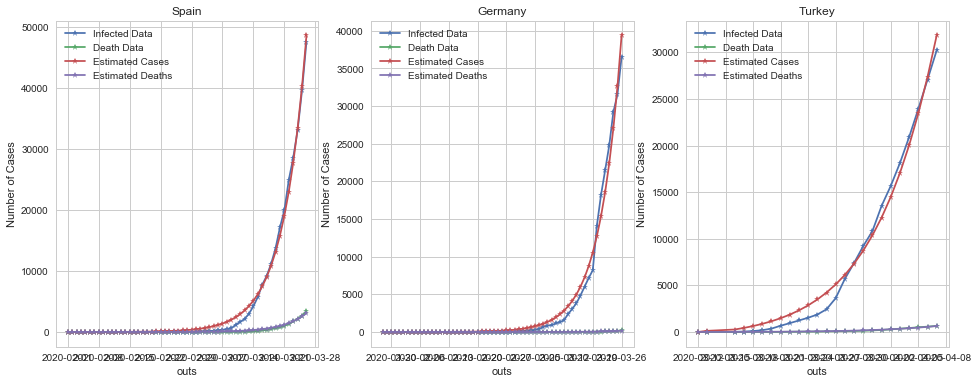

In [15]:
plot_SGT(outs_s, outs_g, outs_t)

The parameters for Spain and Germany look similar, but we can see that they are very different in Turkey. 

In Germany and Spain, the number of cases were staying still for a long time. This was probably because at early stages of the pandemic, testing was not widespread and goverments were not alert. Though Turkey, as the pandemic started at around March 10th, started contact tracing and widespread testing immediately. In fact at March 3rd it had 900 tests with no cases, while US had 400 tests and a death. This clearly illustrates the rapid reaction, which can also be seen in the figure. Thus, the spread rate looks faster for Turkey as it has reliable data, whereas for Germany and Spain, earlier days do not really look realistic.

Let's check the error values of the above. 

In [17]:
print('Error for Spain is:',round(error_value(outs_s[1], outs_s[3]),4))
print('Error for Germany is:',round(error_value(outs_g[1], outs_g[3]),4))
print('Error for Turkey is:',round(error_value(outs_t[1], outs_t[3]),4))

Error for Spain is: 0.0565
Error for Germany is: 0.1077
Error for Turkey is: 0.0775


It seems the models fit the early stages very well, this brings the question: 

     How well will the model work if I assume there are two stages and fit two completely different models for these two stages?
     

## Results

So let's apply a two stage model and check the errors. We can also look at the prediction errors where we estimate values for days we did not see the relevant data to help us understand the effectiveness of the model in terms of prediction. 

In [18]:
def fit_country(data_frame, country, measure_date, N, days_to_predict = 0):
    global y0
    S0 = N-1 # Initial Susceptibles
    I0 = 1 # Initial Cases
    R0 = 0 # Initial Recoveries
    D0 = 0 # Initial Deaths

    y0 = [S0, I0, R0, D0]

    data = get_country(data_frame, country, sep=0)
    dates = data[0]
    d = datetime.strptime(measure_date, '%Y-%m-%d').date()
    msr = np.where(np.array(dates) == d.toordinal())
    first_out = fit_sird(data_frame, country, end=msr)
    
    global second_out
    t = np.arange(len(first_out[0]))
    soln = odeint(f, y0, t, args=tuple(first_out[-1]))
    y0 = soln[-1,:]
    second_out = fit_sird(data_frame, country, start=msr[0]-1, end = len(dates)-days_to_predict)
    dates = np.concatenate((first_out[0], second_out[0]))
    cases = np.concatenate((first_out[1], second_out[1]))
    deaths = np.concatenate((first_out[2], second_out[2]))
    est_cases = np.concatenate((first_out[3], second_out[3]))
    est_deaths = np.concatenate((first_out[4], second_out[4]))
    popt = np.concatenate((first_out[5], second_out[5]))
    
    return dates, cases, deaths, est_cases, est_deaths, popt

The parameters of Spain at initial stage are: beta(S->I) = 0.37 , gamma(I->R) = 0.16 , mu(I->D) = 0.0233
The parameters of Spain at latter stage are: beta(S->I) = 0.35 , gamma(I->R) = 0.34 , mu(I->D) = 0.0408
The parameters of Germany at initial stage are: beta(S->I) = 0.13 , gamma(I->R) = -0.05 , mu(I->D) = 0.0006
The parameters of Germany at latter stage are: beta(S->I) = 0.11 , gamma(I->R) = 0.13 , mu(I->D) = 0.0039
The parameters of Turkey at initial stage are: beta(S->I) = 32.79 , gamma(I->R) = 32.31 , mu(I->D) = 0.2345
The parameters of Turkey at latter stage are: beta(S->I) = 80.42 , gamma(I->R) = 78.47 , mu(I->D) = 1.8784


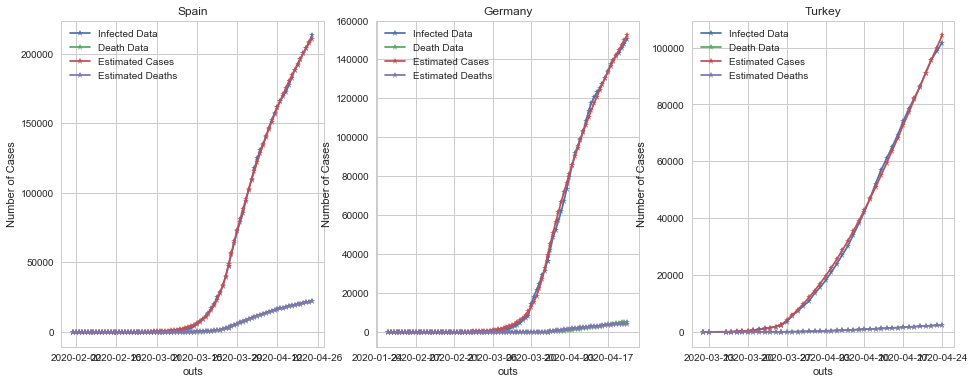

In [19]:
outs_s = fit_country(world_data, country='Spain', measure_date='2020-03-27', N=47*10**6)
outs_g = fit_country(world_data, country='Germany', measure_date='2020-03-27', N=84*10**6)
outs_t = fit_country(world_data, country='Turkey', measure_date='2020-03-27', N=84*10**6)
plot_SGT(outs_s, outs_g, outs_t)

In [20]:
print('Error for Spain is:',round(error_value(outs_s[1], outs_s[3]),4))
print('Error for Germany is:',round(error_value(outs_g[1], outs_g[3]),4))
print('Error for Turkey is:',round(error_value(outs_t[1], outs_t[3]),4))

Error for Spain is: 0.0116
Error for Germany is: 0.025
Error for Turkey is: 0.0218


Now, this looks much better than one stage SIRD. Also, we can see that parameter $\beta$ dropped to less than half its value at the latter stage. These parameters can be thought of the quantified results of the measures. 

We can see that spread rate dropped a lot for Germany and Spain. Weirdly enough, recovery rate fell down for Spain. In the case of Turkey, on the other hand the spread parameter increased even further and recovery rate also jumped. These parameters might be overfitted to the curve as we didn't request the function to also fit the recovery data. So the R part of SIRD is not fitted to anything. We clearly need data for recovered for these parameters to make sense.

Let's leave these model issues to later and see how these parameters do in prediction.

In [21]:
days_to_predict = 10 # Let's predict the last 10 days as we need some data to be able to learn parameters for the second stage.
outs_s = list(fit_country(world_data, country='Spain', measure_date='2020-03-27',
                          N=47*10**6, days_to_predict = days_to_predict))

data = get_country(world_data, 'Spain')
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-(days_to_predict):]).astype(np.float)
outs_s[0] = np.concatenate((outs_s[0], t[1:]))
est = sird_odeint(t, outs_s[5][3], outs_s[5][4], outs_s[5][5]) # Use learnt parameters of the last stage to predict.
pred_cases, pred_deaths = np.split(est, 2)
outs_s[1] = np.cumsum(data[1])
outs_s[2] = np.cumsum(data[2])
outs_s[3] = np.concatenate((outs_s[3], pred_cases[1:]))
outs_s[4] = np.concatenate((outs_s[4], pred_deaths[1:]))

outs_g = list(fit_country(world_data, country='Germany', measure_date='2020-03-27',
                          N=84*10**6, days_to_predict = days_to_predict))
data = get_country(world_data, 'Germany')
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-(days_to_predict):]).astype(np.float)
outs_g[0] = np.concatenate((outs_g[0], t[1:]))
est = sird_odeint(t, outs_g[5][3], outs_g[5][4], outs_g[5][5]) # Use learnt parameters of the last stage to predict.
pred_cases, pred_deaths = np.split(est, 2)
outs_g[1] = np.cumsum(data[1])
outs_g[2] = np.cumsum(data[2])
outs_g[3] = np.concatenate((outs_g[3], pred_cases[1:]))
outs_g[4] = np.concatenate((outs_g[4], pred_deaths[1:]))

outs_t = list(fit_country(world_data, country='Turkey', measure_date='2020-03-27',
                          N=84*10**6, days_to_predict = days_to_predict))
data = get_country(world_data, 'Turkey')
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-(days_to_predict):]).astype(np.float)
outs_t[0] = np.concatenate((outs_t[0], t[1:]))
est = sird_odeint(t, outs_t[5][3], outs_t[5][4], outs_t[5][5]) # Use learnt parameters of the last stage to predict.
pred_cases, pred_deaths = np.split(est, 2)
outs_t[1] = np.cumsum(data[1])
outs_t[2] = np.cumsum(data[2])
outs_t[3] = np.concatenate((outs_t[3], pred_cases[1:]))
outs_t[4] = np.concatenate((outs_t[4], pred_deaths[1:]))

The parameters of Spain at initial stage are: beta(S->I) = 0.37 , gamma(I->R) = 0.16 , mu(I->D) = 0.0233
The parameters of Spain at latter stage are: beta(S->I) = 0.35 , gamma(I->R) = 0.34 , mu(I->D) = 0.0406
The parameters of Germany at initial stage are: beta(S->I) = 0.13 , gamma(I->R) = -0.05 , mu(I->D) = 0.0006
The parameters of Germany at latter stage are: beta(S->I) = 0.1 , gamma(I->R) = 0.11 , mu(I->D) = 0.0027
The parameters of Turkey at initial stage are: beta(S->I) = 32.79 , gamma(I->R) = 32.31 , mu(I->D) = 0.2345
The parameters of Turkey at latter stage are: beta(S->I) = 68.33 , gamma(I->R) = 66.74 , mu(I->D) = 1.5001


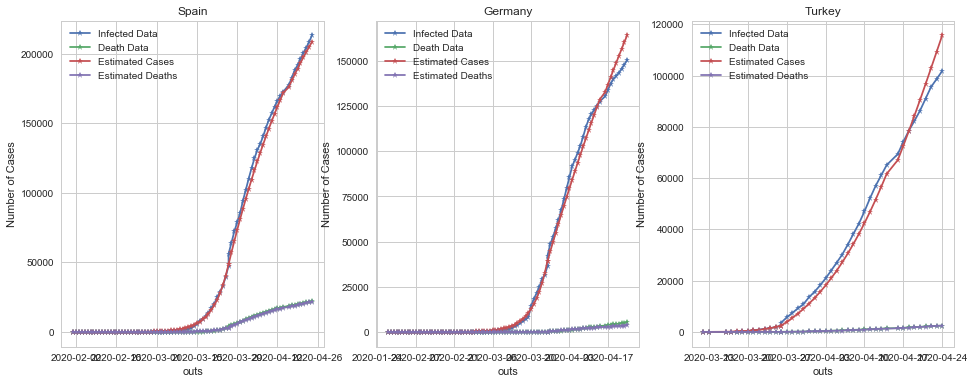

In [22]:
plot_SGT(outs_s, outs_g, outs_t)

In [23]:
print('Error for Spain is:',round(error_value(outs_s[1], outs_s[3]),4))
print('Error for Germany is:',round(error_value(outs_g[1], outs_g[3]),4))
print('Error for Turkey is:',round(error_value(outs_t[1], outs_t[3]),4))

Error for Spain is: 0.0362
Error for Germany is: 0.0558
Error for Turkey is: 0.0835


We can see that for Turkey and Germany, the model tends to overestimate the last 10 days. But it is not too far off and we have seen that with more data the model fits really well.

### Prediction

Now, using our model, let us try to predict the future values for several countries. We are going to predict 80 days which even [experts](https://www.nytimes.com/interactive/2020/04/22/upshot/coronavirus-models.html?algo=top_conversion&fellback=false&imp_id=802743813&imp_id=788768220) refrain from so I would suggest you do not take this seriously.

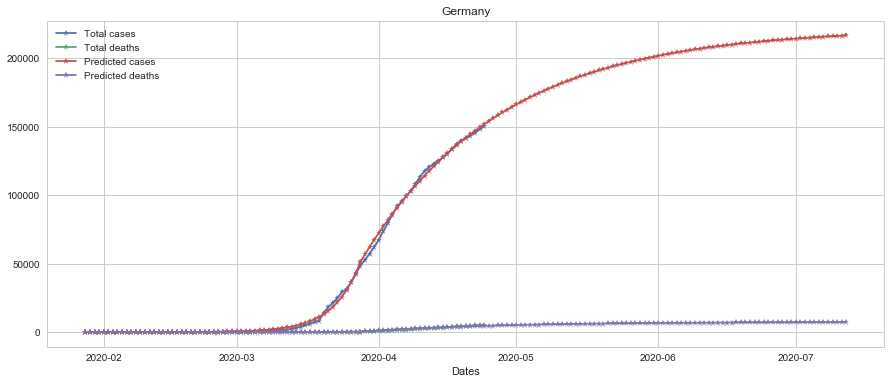

In [26]:
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Germany', measure_date='2020-03-29', 
                                                                N=84*10**6)
data = get_country(world_data, 'Germany')
plt.figure(figsize=figsizes)
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5]) # Use learnt parameters to predict.
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Germany')
plt.xlabel('Dates');

In [27]:
print(popt)
error_value(cases, est_cases)

[0.30334233 0.13051881 0.0015962  0.19429423 0.21875315 0.00811525]


0.02609954227937675

We can state that although case number is projected to increase, deaths do not increase that much. Also it looks like we are probably still at an early phase to model the second part. Still, what we see after the measures is not similar to China, so there might be a need for more precautions. The model looks matching to the current cases but a chnage in societal dynamics, as shown in earlier examples is highly affecting the parameters. 


Let's see Spain, a country that struggled and lost a lot.

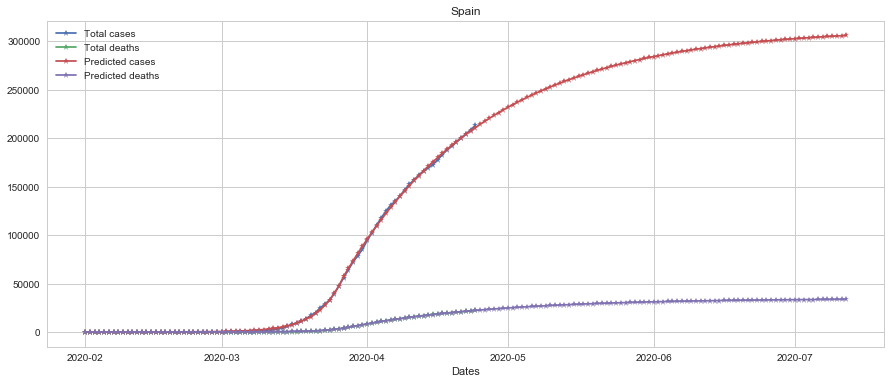

In [30]:
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Spain', measure_date='2020-03-28', 
                                                                N=47*10**6)
data = get_country(world_data, 'Spain')
plt.figure(figsize=figsizes)
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5]) # Use learnt parameters to predict.
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Spain')
plt.xlabel('Dates');

In [31]:
print(popt)
error_value(cases, est_cases)

[0.43270484 0.22046514 0.02855114 0.34077737 0.33081015 0.04090238]


0.011902452440405296

Although the number of deaths do not increase too much, the model shows that the cases will keep increasing. Looking at Spain and Italy, if we compare them with Germany and South Korea, an early lockdown, curfew or other strong measures affected the end results a lot. Thus, we repeat the experts, every day is critical.

Now let's look at Turkey, a late starter in terms of the first case. But before that, let's choose the day with some quantitative selection. We will check 9 different days of inflection (4 days to the past and future) around our guess (March 29th) and take the best fit for current data.

In [32]:
error_list = []
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey',
                                                                measure_date='2020-03-25', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey',
                                                                measure_date='2020-03-26', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', 
                                                                measure_date='2020-03-27', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey',
                                                                measure_date='2020-03-28', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', 
                                                                measure_date='2020-03-29', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', 
                                                                measure_date='2020-03-30', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', 
                                                                measure_date='2020-03-31', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey',
                                                                measure_date='2020-04-01', N=84*10**6)
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', 
                                                                measure_date='2020-04-02',N=84*10**6)
error_list.append(error_value(cases, est_cases))
error_list

[0.03878347051763411,
 0.027407359322468725,
 0.02180130550391481,
 0.02674537409666896,
 0.033663119992450204,
 0.03317425564871676,
 0.1712116026189017,
 0.026950635125211047,
 0.02988516840198759]

Looks like March 27th gives the best fit. Let's see the predictions now. 

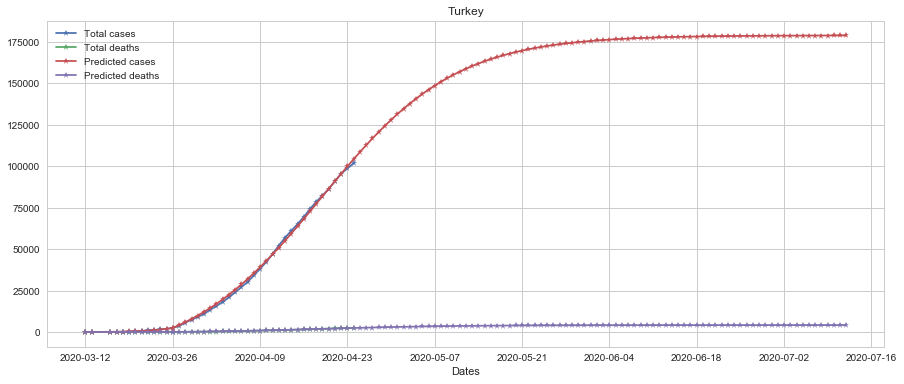

In [33]:
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-27', 
                                                                N=84*10**6)
data = get_country(world_data, 'Turkey')
plt.figure(figsize=figsizes)
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5]) # Use learnt parameters to predict.
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Turkey')
plt.xlabel('Dates');

In [34]:
print(popt)
error_value(cases, est_cases)

[32.79015356 32.30625565  0.23446839 80.42289203 78.46670042  1.87835521]


0.02180130550391481

The parameters are very high which puts the estimates into question. Still, it looks like it's not going to end pretty soon. Also, the government seems to be imposing more restrictions now, so let's hope that the real parameters change and it gets better in a stage 3. 


## Discussion

- In this report we analyzed the COVID-19 Data for case and death count prediction using SIRD model. 
- As the model does not take the parameter changes into account, for an ongoing pandemic it is hard to estimate the best values. 
- Yet, making an assumption in regards to the stages of the pandemic, we were able to create a model that can fit and predict better than the original model. 
- Using the model parameters some predictions were made.
- **The predictions have no implications as the author is not an expert in the subject.**
- It is observed that the model tends to overestimate and is not taking many underlying information into account, still some predictions can easily made regarding the implications of an early lockdown or public awareness. 



## Conclusions

1. Earlier lockdowns, or other measures effect the number of infected greatly, reducing also the death toll. 
2. The two stage model approach can be extended to three or higher stages as sometimes countries take extra measures after a new discovery.
3. The model might be improved using number of tests, recoveries and other data into account. This might provide better and more trustworthy predictions.
4. The model also can be improved to focus on states, cities and counties and their relationship to better explain the underlying dynamics such as connectivity and population density.

### References

[1] “Download Today's Data on the Geographic Distribution of COVID-19 Cases Worldwide.” European Centre for Disease Prevention and Control, 18 Apr. 2020, www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide.

[2] “Compartmental Models in Epidemiology.” Wikipedia, Wikimedia Foundation, 15 Apr. 2020, en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model.